# Addressing Imbalanced Classification with Multiple Models and Feature Selection Strategies

**Author:** Ali Amini  
**Contact:** ali.amini.scholar@gmail.com

## Objective
This repository aims to address the problem of imbalanced classification by implementing and evaluating different machine learning models combined with feature selection strategies. The process involves tuning hyperparameters, selecting the best subset of features, and calibrating model probabilities to achieve optimal performance.

## Dataset Description
The dataset used in this repository comes from a bank marketing campaign. The goal is to predict whether a client will subscribe to a term deposit based on various features. The dataset includes both categorical and numerical features:

- **ID:** Unique identifier for each client.
- **age:** Age of the client.
- **job:** Type of job.
- **marital:** Marital status.
- **education:** Level of education.
- **default:** Whether the client has credit in default.
- **balance:** Account balance.
- **housing:** Whether the client has a housing loan.
- **loan:** Whether the client has a personal loan.
- **contact:** Contact communication type.
- **day:** Last contact day of the month.
- **month:** Last contact month of the year.
- **duration:** Duration of the last contact in seconds.
- **campaign:** Number of contacts performed during this campaign.
- **pdays:** Number of days since the client was last contacted from a previous campaign.
- **previous:** Number of contacts performed before this campaign.
- **poutcome:** Outcome of the previous marketing campaign.
- **subscribed:** Target variable indicating whether the client subscribed to a term deposit.

## Methodology
### 1. Data Preprocessing
- **Encoding Categorical Features:** Used Label Encoding.
- **Handling Numerical Features:** Applied log transformation and Yeo-Johnson transformation.
- **Scaling Features:** Employed StandardScaler and RobustScaler.

### 2. Initial Evaluation for Imbalanced Classification Approaches
- **Methods Evaluated:**
  - SMOTETomek
  - Class Weights
  - Calibrated Probability
- **Validation:** 3-repeated stratified 5-fold cross-validation.
- **Metric:** AUPRC (Average Precision Score).

### 3. Hyperparameter Tuning and Feature Selection
- **Models Implemented:**
  - Random Forest
  - XGBoost
  - KNN
  - Logistic Regression
- **Feature Selection Strategies:**
  - Mutual Information
  - Pearson Correlation
- **Optimization Techniques:**
  - Optuna
- **Calibration:** Used CalibratedClassifierCV for probability calibration.
- **Evaluation Metrics:**
  - AUPRC (Average Precision Score)
  - ROC AUC
  - Confusion Matrix



In [6]:
cd '/content/drive/MyDrive/Bank Dataset'

/content/drive/MyDrive/Bank Dataset


In [7]:
!pip install pandas_profiling

In [8]:
!pip install category_encoders

# Imports


In [9]:
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import HashingEncoder
from category_encoders import WOEEncoder
from category_encoders import BinaryEncoder

from sklearn import metrics
import itertools
import gc
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Reading Data and types of data



In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_back = train.copy()
test_back = test.copy()

numerical_features = [feature for feature in train.columns if train[feature].dtypes != 'O']
print("Numerical_features: ",numerical_features)
categorical_features = [feature for feature in train.columns if train[feature].dtypes == 'O']
print("Categorical_features: ",categorical_features)

train.info()

Numerical_features:  ['ID', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical_features:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'subscribed']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          31647 non-null  int64 
 1   age         31647 non-null  int64 
 2   job         31647 non-null  object
 3   marital     31647 non-null  object
 4   education   31647 non-null  object
 5   default     31647 non-null  object
 6   balance     31647 non-null  int64 
 7   housing     31647 non-null  object
 8   loan        31647 non-null  object
 9   contact     31647 non-null  object
 10  day         31647 non-null  int64 
 11  month       31647 non-null  object
 12  duration    31647 non-null  int64 
 13  campaign    31647 non-null  int64 
 14  pdays       31647

# Box plots of Numerical Columns
Description: This cell visualizes the distribution of numerical features in the dataset using box plots. By examining these plots, we can identify outliers and the spread of the data for each feature. This helps to determine which transformations (e.g., log transformation, power transformation) might be needed to convert the features into a more normal-like distribution, improving the performance of machine learning models. The features visualized include age, balance, duration, campaign, pdays, previous, and day.





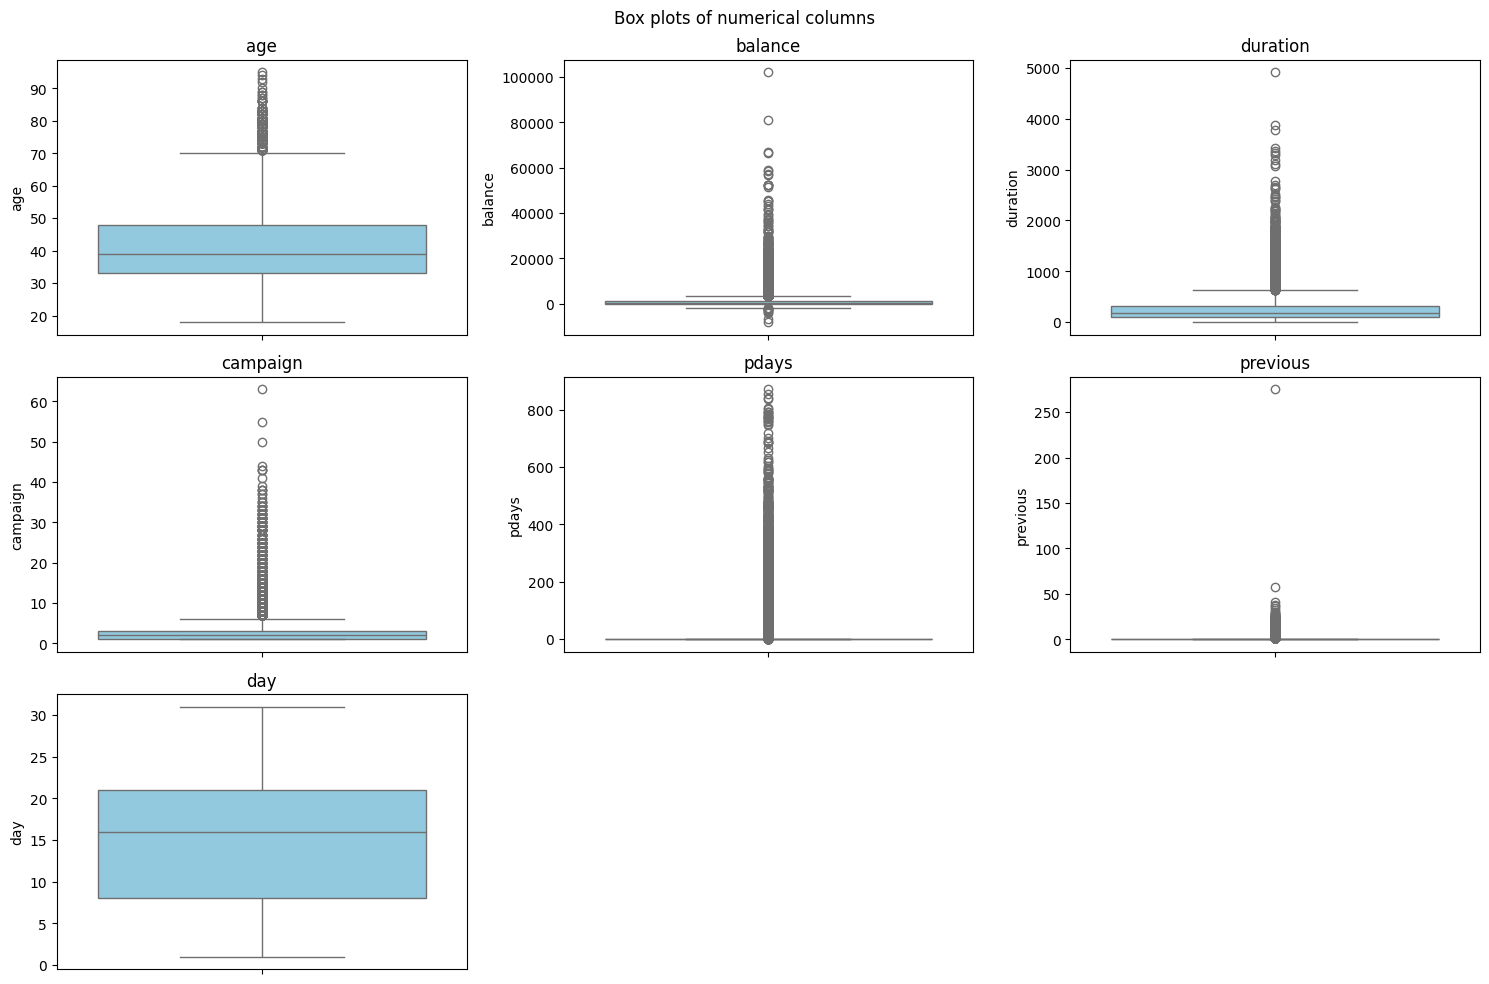

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the dataset
data = {
    'age': train['age'],
    'balance': train['balance'],
    'duration': train['duration'],
    'campaign': train['campaign'],
    'pdays': train['pdays'],
    'previous': train['previous'],
    'day' : train['day']
}

df = pd.DataFrame(data)

# Plotting the box plots using seaborn and matplotlib
plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column], color='skyblue')
    plt.title(column)

plt.suptitle('Box plots of numerical columns')
plt.tight_layout()
plt.show()


# Log Transformation and Plotting
### Applying Log and Yeo-Johnson Transformations

*Description:* This cell applies various transformations to the numerical features in the training and test datasets to handle skewness and make the distributions more normal-like. Specifically:
- Adds small constants to avoid log of zero or negative values for 'duration', 'campaign', 'pdays', and 'previous'.
- Applies log transformation to 'age', 'duration', 'campaign', 'pdays', and 'previous' features in both training and test sets, skipping columns with zero values.
- Uses the Yeo-Johnson transformation for the 'balance' feature to handle negative values.
- Visualizes the distributions of the transformed numerical features using histograms to verify the effect of the transformations.


After log transformation - Min/Max values of age in training set are 2.8903717578961645 - 4.553876891600541
After log transformation - Min/Max values of duration in training set are 0.0 - 8.50086053679534
After log transformation - Min/Max values of campaign in training set are 0.6931471805599453 - 4.1588830833596715
After log transformation - Min/Max values of pdays in training set are 0.0 - 6.771935555839602
After log transformation - Min/Max values of previous in training set are 0.6931471805599453 - 5.6240175061873385
After log transformation - Min/Max values of age in test set are 2.8903717578961645 - 4.553876891600541
After log transformation - Min/Max values of duration in test set are 0.0 - 8.087640287778983
After log transformation - Min/Max values of campaign in test set are 0.6931471805599453 - 4.07753744390572
After log transformation - Min/Max values of pdays in test set are 0.0 - 6.747586526829315
After log transformation - Min/Max values of previous in test set are 0.693

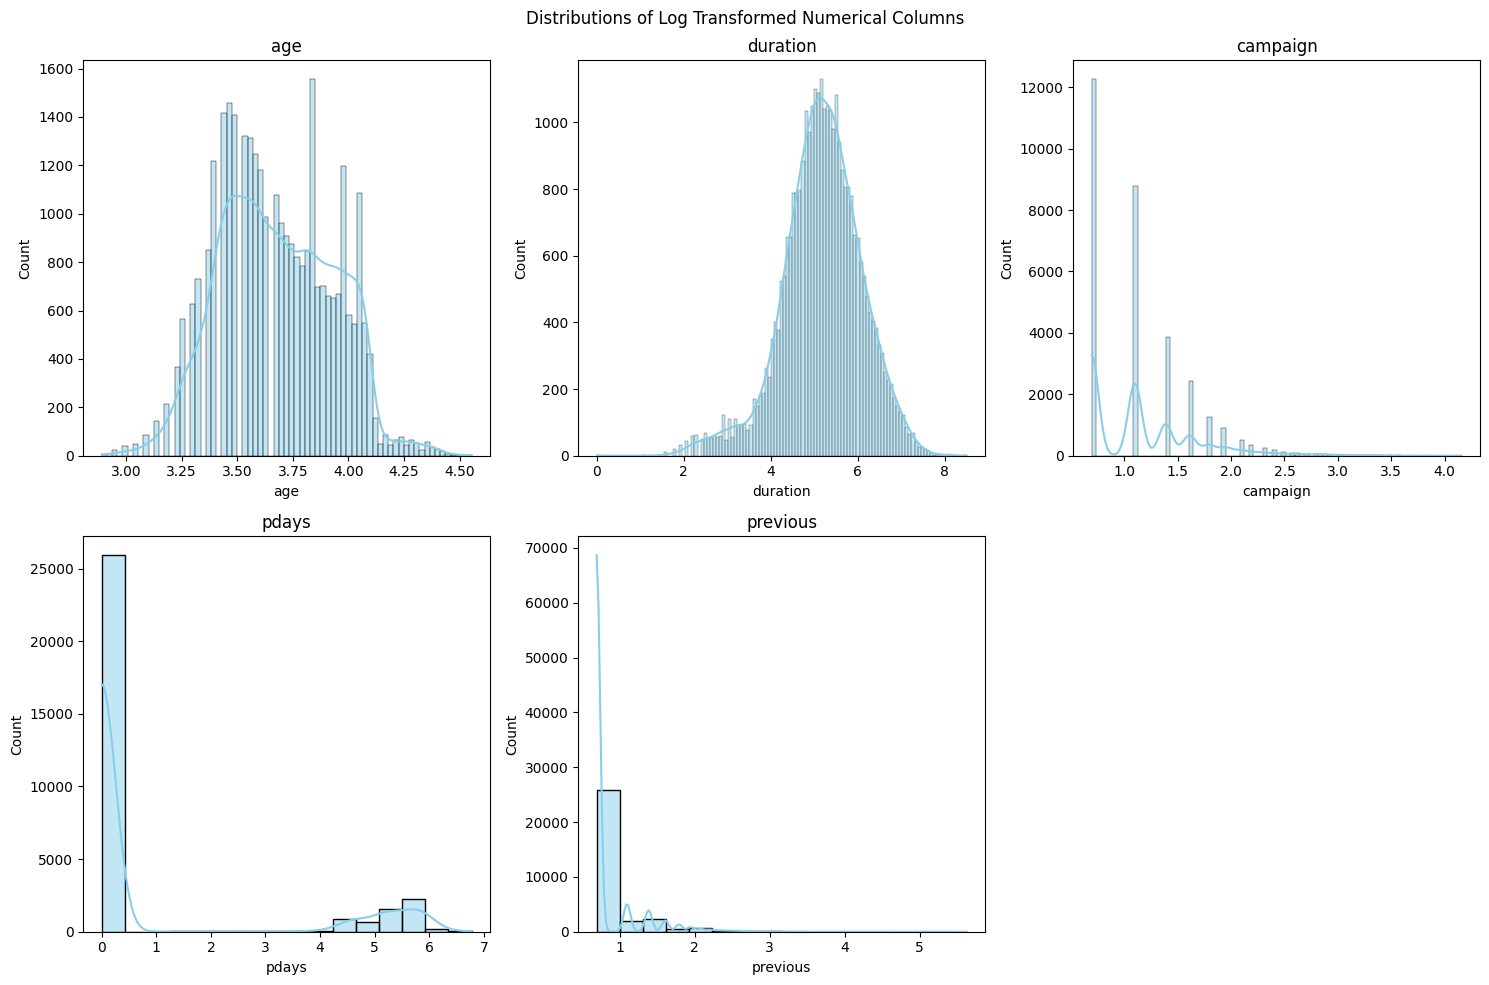

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# Adding small constants to avoid log of zero or negative values for other columns
train['duration'] = train['duration'] + 1
train['campaign'] = train['campaign'] + 1
train['pdays'] = train['pdays'] + 2
train['previous'] = train['previous'] + 2

test['duration'] = test['duration'] + 1
test['campaign'] = test['campaign'] + 1
test['pdays'] = test['pdays'] + 2
test['previous'] = test['previous'] + 2

cols = ['age', 'duration', 'campaign', 'pdays', 'previous']

# Applying log transformation to specified columns in training set
for feature in cols:
    if 0 in train[feature].unique():
        print(f"Skipping log transformation for {feature} due to presence of zero values.")
    else:
        train[feature] = np.log(train[feature])
        print(f"After log transformation - Min/Max values of {feature} in training set are {train[feature].min()} - {train[feature].max()}")

# Applying log transformation to specified columns in test set
for feature in cols:
    if 0 in test[feature].unique():
        print(f"Skipping log transformation for {feature} in test set due to presence of zero values.")
    else:
        test[feature] = np.log(test[feature])
        print(f"After log transformation - Min/Max values of {feature} in test set are {test[feature].min()} - {test[feature].max()}")

# Using Yeo-Johnson transformation for 'balance' to handle negative values
pt = PowerTransformer(method='yeo-johnson')

train['balance'] = pt.fit_transform(train[['balance']])
test['balance'] = pt.transform(test[['balance']])

# Plotting the transformed distributions using seaborn and matplotlib
plt.figure(figsize=(15, 10))

for i, column in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train[column], kde=True, color='skyblue')
    plt.title(column)

plt.suptitle('Distributions of Log Transformed Numerical Columns')
plt.tight_layout()
plt.show()


### Scaling Numerical Features

*Description:* This cell scales the numerical features in the training and test datasets using different scaling methods to standardize the data:
- **StandardScaler:** Applied to the 'age' and 'duration' features to standardize them by removing the mean and scaling to unit variance.
- **RobustScaler:** Applied to 'pdays', 'balance', 'previous', and 'campaign' features to scale them based on the median and interquartile range, making it robust to outliers.
- The scalers are first fitted on the training data and then used to transform both the training and test data to prevent data leakage.


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Define the scalers
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# Fit and transform the train set
train[['age', 'duration']] = standard_scaler.fit_transform(train[['age', 'duration']])
train[['pdays', 'balance', 'previous', 'campaign']] = robust_scaler.fit_transform(train[['pdays', 'balance', 'previous', 'campaign']])

print("Applied StandardScaler to ['age', 'duration']")
print("Applied RobustScaler to ['pdays', 'balance', 'previous', 'campaign']")

# Transform the test set using the same fitted scalers
test[['age', 'duration']] = standard_scaler.transform(test[['age', 'duration']])
test[['pdays', 'balance', 'previous', 'campaign']] = robust_scaler.transform(test[['pdays', 'balance', 'previous', 'campaign']])

print("Applied StandardScaler to ['age', 'duration'] in test set")
print("Applied RobustScaler to ['pdays', 'balance', 'previous', 'campaign'] in test set")

Applied StandardScaler to ['age', 'duration']
Applied RobustScaler to ['pdays', 'balance', 'previous', 'campaign']
Applied StandardScaler to ['age', 'duration'] in test set
Applied RobustScaler to ['pdays', 'balance', 'previous', 'campaign'] in test set


# Unique Values of Various categorical Columns



In [14]:
# List of categorical features
categorical_features = ['job', 'poutcome', 'month', 'contact', 'marital', 'loan', 'education', 'housing', 'default']

# Loop through each categorical feature and print the feature name and its unique values count
for feature in categorical_features:
    unique_values_count = len(train[feature].unique())
    print(f"{feature}: {unique_values_count} unique values")


job: 12 unique values
poutcome: 4 unique values
month: 12 unique values
contact: 3 unique values
marital: 3 unique values
loan: 2 unique values
education: 4 unique values
housing: 2 unique values
default: 2 unique values


# Number of Samples in Each Class
*Description:* This cell calculates and prints the number of samples in each target class of the 'subscribed' column in the training dataset. It demonstrates the class imbalance in the dataset.

In [15]:
# Calculate the number of samples in each target class
target_counts = train['subscribed'].value_counts()

# Print the number of samples in each target class
print("Number of samples in each target class:")
for class_label, count in target_counts.items():
    print(f"{class_label}: {count}")


Number of samples in each target class:
no: 27932
yes: 3715


In [16]:
train

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,1.356656,admin.,married,unknown,no,0.990908,no,no,telephone,19,nov,-1.491980,0.000000,0.000000,0.000000,unknown,no
1,40576,-0.965997,unknown,married,secondary,no,-0.405034,no,no,cellular,20,jul,-0.711902,0.000000,0.000000,0.000000,unknown,no
2,15320,-1.508599,services,married,secondary,no,0.319580,yes,no,cellular,18,jul,0.338572,-0.584963,0.000000,0.000000,unknown,no
3,43962,1.426173,management,divorced,tertiary,no,1.780150,no,no,cellular,22,jun,1.736351,-0.584963,4.454347,0.916291,success,yes
4,29842,-0.965997,technician,married,secondary,no,-0.277172,yes,no,cellular,4,feb,0.838173,-0.584963,0.000000,0.000000,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,36483,-1.227936,management,single,tertiary,no,-0.410383,yes,no,cellular,12,may,-0.449683,0.000000,0.000000,0.000000,unknown,no
31643,40178,1.140402,management,divorced,tertiary,no,-0.054572,no,yes,cellular,5,jun,0.992743,0.000000,0.000000,0.000000,unknown,yes
31644,19710,-0.841301,management,single,tertiary,no,-0.109144,no,no,cellular,7,aug,-1.676413,0.415037,0.000000,0.000000,unknown,no
31645,38556,1.426173,technician,married,secondary,no,-0.181871,yes,no,telephone,15,may,-2.224108,1.415037,5.826000,1.945910,failure,no


In [17]:
train_back

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31642,36483,29,management,single,tertiary,no,0,yes,no,cellular,12,may,116,2,-1,0,unknown,no
31643,40178,53,management,divorced,tertiary,no,380,no,yes,cellular,5,jun,438,2,-1,0,unknown,yes
31644,19710,32,management,single,tertiary,no,312,no,no,cellular,7,aug,37,3,-1,0,unknown,no
31645,38556,57,technician,married,secondary,no,225,yes,no,telephone,15,may,22,7,337,12,failure,no


### Encoding Categorical Features and Initial Evaluation for Imbalanced Classification Approaches

*Description:* This step involves encoding categorical features using different methods and evaluating which encoding method works best for the problem of imbalanced classification.

1. **Label Encoding:**
   - **Process:** Converts categorical values into numeric labels. Each unique category value is assigned a unique integer.
   - **Usage:** Suitable for ordinal data or when there are no significant order differences between categories.
   - **Evaluation:** Implemented Label Encoding and applied Logistic Regression and Random Forest models. Used 3-repeated stratified 5-fold cross-validation to evaluate performance with AUPRC as the metric.

2. **One-Hot Encoding:**
   - **Process:** Converts categorical values into a series of binary columns. Each category value is converted into a new column and assigned a binary value.
   - **Usage:** Suitable for nominal data where there is no ordinal relationship between categories.
   - **Evaluation:** Implemented One-Hot Encoding and applied Logistic Regression and Random Forest models. Used the same cross-validation and evaluation metric as for Label Encoding.

3. **Target Encoding:**
   - **Process:** Encodes categorical values using the target variable. Each category value is replaced with the mean of the target variable for that category.
   - **Usage:** Useful when there is a strong relationship between the categorical feature and the target variable.
   - **Evaluation:** Implemented Target Encoding with smoothing and applied Logistic Regression and Random Forest models. Used the same cross-validation and evaluation metric.

4. **Hashing Encoding:**
   - **Process:** Uses a hashing function to convert categorical values into numeric values. This can reduce the dimensionality of the dataset.
   - **Usage:** Suitable for high-cardinality features where One-Hot Encoding would create too many columns.
   - **Evaluation:** Implemented Hashing Encoding and applied Logistic Regression and Random Forest models. Used the same cross-validation and evaluation metric.

*Selection Criteria:*
- **Performance Metric:** Average Precision Score (AUPRC) was used as the main metric to evaluate the encoding methods.
- **Model Compatibility:** Evaluated the performance of Logistic Regression and Random Forest models with each encoding method.
- **Overall Performance:** The encoding method that yielded the highest AUPRC score with the given models was selected as the best method for further analysis.


# Initialization For Encoding

In [18]:
import numpy as np
import pandas as pd
import gc
import warnings
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from category_encoders import TargetEncoder, HashingEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define helper function to get scores for each encoding method
def get_cv_scores(model, X, y, cv):
    auc_scores = []
    auprc_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc_score = roc_auc_score(y_val, y_pred)
        auprc_score = average_precision_score(y_val, y_pred)

        auc_scores.append(auc_score)
        auprc_scores.append(auprc_score)

    return np.mean(auc_scores), np.mean(auprc_scores)

target_feature = 'subscribed'
SEED = 123

logit = LogisticRegression(random_state=SEED, solver='saga')
rf = RandomForestClassifier(random_state=SEED)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

cat_features = [feature for feature in train.columns if train[feature].dtype == 'O']
cat_features.append('day')
print("Removed columns - ", cat_features.pop(-2))

Removed columns -  subscribed


In [19]:
train, cat_features

(          ID       age         job   marital  education default   balance  \
 0      26110  1.356656      admin.   married    unknown      no  0.990908   
 1      40576 -0.965997     unknown   married  secondary      no -0.405034   
 2      15320 -1.508599    services   married  secondary      no  0.319580   
 3      43962  1.426173  management  divorced   tertiary      no  1.780150   
 4      29842 -0.965997  technician   married  secondary      no -0.277172   
 ...      ...       ...         ...       ...        ...     ...       ...   
 31642  36483 -1.227936  management    single   tertiary      no -0.410383   
 31643  40178  1.140402  management  divorced   tertiary      no -0.054572   
 31644  19710 -0.841301  management    single   tertiary      no -0.109144   
 31645  38556  1.426173  technician   married  secondary      no -0.181871   
 31646  14156  1.285886  management  divorced  secondary      no -0.200049   
 
       housing loan    contact  day month  duration  campaign 

In [20]:
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'day']

# Label Encoding

In [21]:
# Label Encoding
lb_train = train.copy()
lb_test = test.copy()

label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    lb_train[feature] = label_encoder.fit_transform(lb_train[feature])
    lb_test[feature] = label_encoder.transform(lb_test[feature])

lb_train[target_feature] = lb_train[target_feature].map({"yes": 1, "no": 0})
lb_y = lb_train[target_feature]
lb_train.drop([target_feature], axis=1, inplace=True)

# Split dataset into features and target
X_lb = lb_train.values
y_lb = lb_y.values

logit_auc_lb, logit_auprc_lb = get_cv_scores(logit, X_lb, y_lb, cv)
print('Logistic Regression ROC AUC score with Label Encoding:', logit_auc_lb)
print('Logistic Regression AUPRC score with Label Encoding:', logit_auprc_lb)

rf_auc_lb, rf_auprc_lb = get_cv_scores(rf, X_lb, y_lb, cv)
print('Random Forest ROC AUC score with Label Encoding:', rf_auc_lb)
print('Random Forest AUPRC score with Label Encoding:', rf_auprc_lb)

del lb_train
gc.collect()
del lb_test
gc.collect()

Logistic Regression ROC AUC score with Label Encoding: 0.23457030569542583
Logistic Regression AUPRC score with Label Encoding: 0.07197103560183767
Random Forest ROC AUC score with Label Encoding: 0.9428827854934279
Random Forest AUPRC score with Label Encoding: 0.6491089182589728


34030

# one-hot Encoding

In [22]:
# One-Hot Encoding
ohe_train = train.copy()
ohe_test = test.copy()

one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

ohe_train[target_feature] = ohe_train[target_feature].map({"yes": 1, "no": 0})
ohe_y = ohe_train[target_feature]
ohe_train.drop([target_feature], axis=1, inplace=True)

ohe_train = one_hot_enc.fit_transform(ohe_train[cat_features])
ohe_test = one_hot_enc.transform(ohe_test[cat_features])

# Split dataset into features and target
X_ohe = ohe_train
y_ohe = ohe_y.values

logit_auc_ohe, logit_auprc_ohe = get_cv_scores(logit, X_ohe, y_ohe, cv)
print('Logistic Regression ROC AUC score with One-Hot Encoding:', logit_auc_ohe)
print('Logistic Regression AUPRC score with One-Hot Encoding:', logit_auprc_ohe)

rf_auc_ohe, rf_auprc_ohe = get_cv_scores(rf, X_ohe, y_ohe, cv)
print('Random Forest ROC AUC score with One-Hot Encoding:', rf_auc_ohe)
print('Random Forest AUPRC score with One-Hot Encoding:', rf_auprc_ohe)

del ohe_train
gc.collect()
del ohe_test
gc.collect()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Logistic Regression ROC AUC score with One-Hot Encoding: 0.7651766890185996
Logistic Regression AUPRC score with One-Hot Encoding: 0.40365834809192375
Random Forest ROC AUC score with One-Hot Encoding: 0.7486978859464204
Random Forest AUPRC score with One-Hot Encoding: 0.34505560241546385


0

# Target Encoding

In [23]:
# Target Encoding
te_train = train.copy()
te_test = test.copy()

label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    te_train[feature] = label_encoder.fit_transform(te_train[feature])
    te_test[feature] = label_encoder.transform(te_test[feature])

te_train[target_feature] = te_train[target_feature].map({"yes": 1, "no": 0})
te_y = te_train[target_feature]
te_train.drop([target_feature], axis=1, inplace=True)

targ_enc = TargetEncoder(cols=cat_features, smoothing=8, min_samples_leaf=5).fit(te_train, te_y)
te_train = targ_enc.transform(te_train.reset_index(drop=True))
te_test = targ_enc.transform(te_test.reset_index(drop=True))

# Split dataset into features and target
X_te = te_train.values
y_te = te_y.values

logit_auc_te, logit_auprc_te = get_cv_scores(logit, X_te, y_te, cv)
print('Logistic Regression ROC AUC score with Target Encoding:', logit_auc_te)
print('Logistic Regression AUPRC score with Target Encoding:', logit_auprc_te)

rf_auc_te, rf_auprc_te = get_cv_scores(rf, X_te, y_te, cv)
print('Random Forest ROC AUC score with Target Encoding:', rf_auc_te)
print('Random Forest AUPRC score with Target Encoding:', rf_auprc_te)

del te_train
gc.collect()
del te_test
gc.collect()

Logistic Regression ROC AUC score with Target Encoding: 0.2342148091975139
Logistic Regression AUPRC score with Target Encoding: 0.07195831074366836
Random Forest ROC AUC score with Target Encoding: 0.9423486301411818
Random Forest AUPRC score with Target Encoding: 0.6506379645306379


0

# Hashing Encoding

In [24]:
# Hashing Encoding
he_train = train.copy()
he_test = test.copy()

label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    he_train[feature] = label_encoder.fit_transform(he_train[feature])
    he_test[feature] = label_encoder.transform(he_test[feature])

he_train[target_feature] = he_train[target_feature].map({"yes": 1, "no": 0})
he_y = he_train[target_feature]
he_train.drop([target_feature], axis=1, inplace=True)

hash_enc = HashingEncoder(cols=cat_features, n_components=5).fit(he_train, he_y)
he_train = hash_enc.transform(he_train.reset_index(drop=True))
he_test = hash_enc.transform(he_test.reset_index(drop=True))

# Split dataset into features and target
X_he = he_train.values
y_he = he_y.values

logit_auc_he, logit_auprc_he = get_cv_scores(logit, X_he, y_he, cv)
print('Logistic Regression ROC AUC score with Hashing Encoding:', logit_auc_he)
print('Logistic Regression AUPRC score with Hashing Encoding:', logit_auprc_he)

rf_auc_he, rf_auprc_he = get_cv_scores(rf, X_he, y_he, cv)
print('Random Forest ROC AUC score with Hashing Encoding:', rf_auc_he)
print('Random Forest AUPRC score with Hashing Encoding:', rf_auprc_he)

del he_train
gc.collect()
del he_test
gc.collect()

Logistic Regression ROC AUC score with Hashing Encoding: 0.23424860275250806
Logistic Regression AUPRC score with Hashing Encoding: 0.07196307540409065
Random Forest ROC AUC score with Hashing Encoding: 0.9362583236823612
Random Forest AUPRC score with Hashing Encoding: 0.6170545194550365


0

### Addressing Imbalanced Classification

*Description:* This step involves addressing the issue of imbalanced classification using various techniques and evaluating their effectiveness. The techniques evaluated are SMOTETomek, class weights, and calibrated probability.

1. **SMOTETomek:**
   - **Process:** Combines Synthetic Minority Over-sampling Technique (SMOTE) and Tomek links. SMOTE generates synthetic samples for the minority class, while Tomek links are used to remove overlapping samples from both classes.
   - **Usage:** Useful for balancing the dataset by increasing the number of minority class samples and reducing class overlap.
   - **Evaluation:** Implemented SMOTETomek with Logistic Regression and Random Forest models. Used 3-repeated stratified 5-fold cross-validation to evaluate performance with AUPRC as the metric.

2. **Class Weights:**
   - **Process:** Adjusts the weights of classes inversely proportional to their frequencies in the dataset. This helps to give more importance to the minority class during training.
   - **Usage:** Suitable for algorithms that support class weights natively, like Logistic Regression and Random Forest.
   - **Evaluation:** Applied class weights with Logistic Regression and Random Forest models. Used the same cross-validation and evaluation metric as for SMOTETomek.

3. **Calibrated Probability:**
   - **Process:** Uses a calibration technique to adjust the predicted probabilities of a classifier. This ensures that the predicted probabilities are more reliable.
   - **Usage:** Suitable for models where the predicted probabilities need to be accurate, such as when using threshold-based decision-making.
   - **Evaluation:** Applied CalibratedClassifierCV with Logistic Regression and Random Forest models. Used the same cross-validation and evaluation metric.

*Selection Criteria:*
- **Performance Metric:** Average Precision Score (AUPRC) was used as the main metric to evaluate the imbalanced classification techniques.
- **Model Compatibility:** Evaluated the performance of Logistic Regression and Random Forest models with each technique.
- **Overall Performance:** The imbalanced classification technique that yielded the highest AUPRC score with the given models was selected as the best method for further analysis.

*Outcome:*
After evaluating the different techniques, it was observed that the **calibrated probability method consistently provided better results** in comparison to SMOTETomek and class weights. Therefore, the calibrated probability method was selected for addressing the imbalanced classification problem in the subsequent steps.


# Initialization For Imbalanced Classification Challenge





In [25]:
import numpy as np
import pandas as pd
import gc
import warnings
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from category_encoders import TargetEncoder, HashingEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define helper function to get scores for each encoding method
def get_cv_scores(model, X, y, cv):
    auc_scores = []
    auprc_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc_score = roc_auc_score(y_val, y_pred)
        auprc_score = average_precision_score(y_val, y_pred)

        auc_scores.append(auc_score)
        auprc_scores.append(auprc_score)

    return np.mean(auc_scores), np.mean(auprc_scores)

target_feature = 'subscribed'
SEED = 123

logit = LogisticRegression(random_state=SEED, solver='saga')
rf = RandomForestClassifier(random_state=SEED)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

cat_features = [feature for feature in train.columns if train[feature].dtype == 'O']
cat_features.append('day')
print("Removed columns - ", cat_features.pop(-2))

train_before_label_encode = train.copy()
test_before_label_encode = test.copy()
# Label Encoding
le = preprocessing.LabelEncoder()
for feature in cat_features:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])

train[target_feature] = train[target_feature].map({"yes": 1, "no": 0})
y = train[target_feature].values
X = train.drop([target_feature], axis=1).values


Removed columns -  subscribed


# SMOTETomek

In [26]:

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

smotetomek = SMOTETomek(random_state=SEED)

# Logistic Regression with SMOTETomek
pipeline_smote_logit = Pipeline([('smotetomek', smotetomek), ('classifier', logit)])
logit_auc_smote, logit_auprc_smote = get_cv_scores(pipeline_smote_logit, X, y, cv)
print('Logistic Regression ROC AUC score with SMOTETomek:', logit_auc_smote)
print('Logistic Regression AUPRC score with SMOTETomek:', logit_auprc_smote)

# Random Forest with SMOTETomek
pipeline_smote_rf = Pipeline([('smotetomek', smotetomek), ('classifier', rf)])
rf_auc_smote, rf_auprc_smote = get_cv_scores(pipeline_smote_rf, X, y, cv)
print('Random Forest ROC AUC score with SMOTETomek:', rf_auc_smote)
print('Random Forest AUPRC score with SMOTETomek:', rf_auprc_smote)


Logistic Regression ROC AUC score with SMOTETomek: 0.7584998795517203
Logistic Regression AUPRC score with SMOTETomek: 0.3416750734934919
Random Forest ROC AUC score with SMOTETomek: 0.9394230302584925
Random Forest AUPRC score with SMOTETomek: 0.6215974793587234


# Class Weight

In [27]:

# Logistic Regression with class weight
logit_weighted = LogisticRegression(random_state=SEED, solver='saga', class_weight='balanced')
logit_auc_weighted, logit_auprc_weighted = get_cv_scores(logit_weighted, X, y, cv)
print('Logistic Regression ROC AUC score with class weight:', logit_auc_weighted)
print('Logistic Regression AUPRC score with class weight:', logit_auprc_weighted)

# Random Forest with class weight
rf_weighted = RandomForestClassifier(random_state=SEED, class_weight='balanced')
rf_auc_weighted, rf_auprc_weighted = get_cv_scores(rf_weighted, X, y, cv)
print('Random Forest ROC AUC score with class weight:', rf_auc_weighted)
print('Random Forest AUPRC score with class weight:', rf_auprc_weighted)


Logistic Regression ROC AUC score with class weight: 0.7624896986858307
Logistic Regression AUPRC score with class weight: 0.35029294988922804
Random Forest ROC AUC score with class weight: 0.9422036804227362
Random Forest AUPRC score with class weight: 0.6435814681296932


# Calibrated Probability



In [28]:

from sklearn.calibration import CalibratedClassifierCV

# Calibrated Logistic Regression
calibrated_logit = CalibratedClassifierCV(base_estimator=logit, method='sigmoid', cv=cv)
logit_auc_calibrated, logit_auprc_calibrated = get_cv_scores(calibrated_logit, X, y, cv)
print('Logistic Regression ROC AUC score with calibrated probability:', logit_auc_calibrated)
print('Logistic Regression AUPRC score with calibrated probability:', logit_auprc_calibrated)

# Calibrated Random Forest
calibrated_rf = CalibratedClassifierCV(base_estimator=rf, method='sigmoid', cv=cv)
rf_auc_calibrated, rf_auprc_calibrated = get_cv_scores(calibrated_rf, X, y, cv)
print('Random Forest ROC AUC score with calibrated probability:', rf_auc_calibrated)
print('Random Forest AUPRC score with calibrated probability:', rf_auprc_calibrated)


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:32

Logistic Regression ROC AUC score with calibrated probability: 0.7656862896263863
Logistic Regression AUPRC score with calibrated probability: 0.3579813109462059


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:32

Random Forest ROC AUC score with calibrated probability: 0.9451543928519395
Random Forest AUPRC score with calibrated probability: 0.6615379123491727


In [29]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00


### Optimizing Number of Features, Model, and Hyperparameter Tuning

*Description:* This section focuses on optimizing the number of features, selecting the best model, and tuning hyperparameters using two different feature selection methods: Mutual Information and Pearson Correlation. The process involves employing various machine learning models and utilizing Optuna for hyperparameter optimization. The models are evaluated using label encoding and calibrated probability.

1. **Feature Selection Methods:**
   - **Mutual Information:** Measures the dependency between each feature and the target variable. Higher mutual information indicates a stronger relationship.
   - **Pearson Correlation:** Measures the linear relationship between each feature and the target variable. Features with higher absolute correlation values are considered more relevant.

2. **Machine Learning Models:**
   - **Random Forest (RF)**
   - **XGBoost (XGB)**
   - **K-Nearest Neighbors (KNN)**
   - **Logistic Regression (LR)**

3. **Optimization Technique:**
   - **Optuna:** An open-source hyperparameter optimization framework that uses a form of Bayesian optimization. It efficiently searches the hyperparameter space to find the best combination of hyperparameters.
   - **Calibrated Probability:** CalibratedClassifierCV is used to ensure that the predicted probabilities are reliable.
   - The number of trials for optimization is set to 5, reducing the execution time and resources.

4. **Process:**
   - **Feature Selection:** For each feature selection method (Mutual Information and Pearson Correlation), the optimal number of features is determined.
   - **Model Training and Hyperparameter Tuning:** For each model, the best hyperparameters are searched using Optuna. The models are evaluated using Stratified 5-fold cross-validation with AUPRC as the metric.
   - **Evaluation on Test Set:** The best model and hyperparameters are then used to train the model on the entire training set. The performance is evaluated on the test set using AUPRC, ROC AUC, and the confusion matrix.

*Steps:*

1. **Define the Objective Function for Optuna:**
   - The objective function is defined for each combination of model and feature selection method. It includes steps for feature selection, model training, hyperparameter tuning, and evaluation.

2. **Initialize Optuna Study:**
   - Optuna's study object is initialized for each model and feature selection method combination. The direction is set to "maximize" as we aim to maximize the AUPRC.

3. **Optimize Hyperparameters:**
   - The study object is used to perform the optimization, which involves multiple trials to find the best hyperparameters for each model and feature selection method combination.

4. **Retrain the Model:**
   - The model with the best hyperparameters is retrained on the entire training set using the selected features. Label encoding and calibrated probability are applied.


*Outcome:*
It shows that tuning using Mutual Information as the feature selection strategy enhanced the AUPRC in comparison to the Pearson Correlation.


# Initialization For Hyperparameter Tuning & Feature Selection


In [30]:
import numpy as np
import pandas as pd
import gc
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.experimental import enable_halving_search_cv
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline
import optuna

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define helper function to get scores for each encoding method
def get_auprc_score(model, X, y, cv):
    scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        score = average_precision_score(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)

# Define function to evaluate the model on the test set
def evaluate_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_test = model.predict_proba(X_test)[:, 1]
    y_train_pred_label = model.predict(X_train)
    train_auprc = average_precision_score(y_train, y_pred_train)
    train_roc_auc_score = roc_auc_score(y_train, y_pred_train)
    y_test_pred_label = model.predict(X_test)
    cm = confusion_matrix(y_train, y_train_pred_label)
    cr = classification_report(y_train, y_train_pred_label)


    return train_auprc, train_roc_auc_score,cm, cr

target_feature = 'subscribed'
SEED = 123

logit = LogisticRegression(random_state=SEED, solver='saga')
rf = RandomForestClassifier(random_state=SEED)
knn = KNeighborsClassifier()
svc = SVC(probability=True, random_state=SEED)
xgb = XGBClassifier(random_state=SEED)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'day']

# Label Encoding
le = LabelEncoder()
for feature in cat_features:
    train[feature] = le.fit_transform(train_before_label_encode[feature])
    test[feature] = le.transform(test_before_label_encode[feature])

train[target_feature] = train_before_label_encode[target_feature].map({"yes": 1, "no": 0})

y = train[target_feature].values
X = train.drop([target_feature], axis=1)

X.drop(['ID'],axis= 1, inplace=True)

X_test = test
X_test.drop(['ID'],axis= 1, inplace=True)

# RandomForest + Pearson Correlation




In [31]:
def objective_rf_pearson(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=k)),
        ('calibrated_rf', CalibratedClassifierCV(base_estimator=RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=SEED), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_rf_pearson = optuna.create_study(direction='maximize')
study_rf_pearson.optimize(objective_rf_pearson, n_trials=5)

best_params_rf_pearson = study_rf_pearson.best_params
best_score_rf_pearson = study_rf_pearson.best_value

print("Best params (RF + Pearson):", best_params_rf_pearson)
print("Best score (RF + Pearson):", best_score_rf_pearson)

# Capture the best k features
best_k_rf_pearson = best_params_rf_pearson['k']
selected_features_rf_pearson = SelectKBest(f_classif, k=best_k_rf_pearson).fit(X, y).get_support(indices=True)
X_selected_rf_pearson = X.iloc[:, selected_features_rf_pearson]
X_test_selected_rf_pearson = X_test.iloc[:, selected_features_rf_pearson]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_rf_pearson = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=best_k_rf_pearson)),
    ('calibrated_rf', CalibratedClassifierCV(base_estimator=RandomForestClassifier(
        n_estimators=best_params_rf_pearson['n_estimators'], max_depth=best_params_rf_pearson['max_depth'],
        min_samples_split=best_params_rf_pearson['min_samples_split'], min_samples_leaf=best_params_rf_pearson['min_samples_leaf'],
        bootstrap=best_params_rf_pearson['bootstrap'], random_state=SEED), method='sigmoid', cv=cv))
])

train_auprc_rf_pearson, train_roc_auc_rf_pearson, cm_rf_pearson, cr_rf_pearson = evaluate_model(
    pipeline_rf_pearson, X_selected_rf_pearson, y, X_test_selected_rf_pearson)

print(f"Train AUPRC (RF + Pearson): {train_auprc_rf_pearson}")
print(f"Train ROC AUC (RF + Pearson): {train_roc_auc_rf_pearson}")
print("Confusion Matrix (RF + Pearson):\n", cm_rf_pearson)
print("Classification Report (RF + Pearson):\n", cr_rf_pearson)

[I 2024-06-14 21:47:01,481] A new study created in memory with name: no-name-538e3d2d-6575-4af2-ac3f-578d826f324b
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 

Best params (RF + Pearson): {'k': 14, 'n_estimators': 165, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'bootstrap': False}
Best score (RF + Pearson): 0.6084509413557806
Train AUPRC (RF + Pearson): 0.9824507929214178
Train ROC AUC (RF + Pearson): 0.9973579076584567
Confusion Matrix (RF + Pearson):
 [[27874    58]
 [  648  3067]]
Classification Report (RF + Pearson):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     27932
           1       0.98      0.83      0.90      3715

    accuracy                           0.98     31647
   macro avg       0.98      0.91      0.94     31647
weighted avg       0.98      0.98      0.98     31647



# Random Forest + Mutual Information


In [32]:
def objective_rf_mi(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(mutual_info_classif, k=k)),
        ('calibrated_rf', CalibratedClassifierCV(base_estimator=RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=SEED), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_rf_mi = optuna.create_study(direction='maximize')
study_rf_mi.optimize(objective_rf_mi, n_trials=5)

best_params_rf_mi = study_rf_mi.best_params
best_score_rf_mi = study_rf_mi.best_value

print("Best params (RF + MI):", best_params_rf_mi)
print("Best score (RF + MI):", best_score_rf_mi)

# Capture the best k features
best_k_rf_mi = best_params_rf_mi['k']
selected_features_rf_mi = SelectKBest(mutual_info_classif, k=best_k_rf_mi).fit(X, y).get_support(indices=True)
X_selected_rf_mi = X.iloc[:, selected_features_rf_mi]
X_test_selected_rf_mi = X_test.iloc[:, selected_features_rf_mi]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_rf_mi = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=best_k_rf_mi)),
    ('calibrated_rf', CalibratedClassifierCV(base_estimator=RandomForestClassifier(
        n_estimators=best_params_rf_mi['n_estimators'], max_depth=best_params_rf_mi['max_depth'],
        min_samples_split=best_params_rf_mi['min_samples_split'], min_samples_leaf=best_params_rf_mi['min_samples_leaf'],
        bootstrap=best_params_rf_mi['bootstrap'], random_state=SEED), method='sigmoid', cv=cv))
])

train_auprc_rf_mi, train_roc_auc_rf_mi, cm_rf_mi, cr_rf_mi = evaluate_model(
    pipeline_rf_mi, X_selected_rf_mi, y, X_test_selected_rf_mi)

print(f"Train AUPRC (RF + MI): {train_auprc_rf_mi}")
print(f"Train ROC AUC (RF + MI): {train_roc_auc_rf_mi}")
print("Confusion Matrix (RF + MI):\n", cm_rf_mi)
print("Classification Report (RF + MI):\n", cr_rf_mi)

[I 2024-06-14 21:57:16,054] A new study created in memory with name: no-name-8346ac14-5959-45cc-a1d1-96056ede041a
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 

Best params (RF + MI): {'k': 13, 'n_estimators': 264, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4, 'bootstrap': True}
Best score (RF + MI): 0.6059192944071647


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train AUPRC (RF + MI): 0.825512130425424
Train ROC AUC (RF + MI): 0.9661723848091761
Confusion Matrix (RF + MI):
 [[27512   420]
 [ 1459  2256]]
Classification Report (RF + MI):
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     27932
           1       0.84      0.61      0.71      3715

    accuracy                           0.94     31647
   macro avg       0.90      0.80      0.84     31647
weighted avg       0.94      0.94      0.94     31647



# XGBoost + Pearson Correlation


In [33]:
def objective_xgb_pearson(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=k)),
        ('calibrated_xgb', CalibratedClassifierCV(base_estimator=XGBClassifier(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
            subsample=subsample, colsample_bytree=colsample_bytree, random_state=SEED), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_xgb_pearson = optuna.create_study(direction='maximize')
study_xgb_pearson.optimize(objective_xgb_pearson, n_trials=5)

best_params_xgb_pearson = study_xgb_pearson.best_params
best_score_xgb_pearson = study_xgb_pearson.best_value

print("Best params (XGB + Pearson):", best_params_xgb_pearson)
print("Best score (XGB + Pearson):", best_score_xgb_pearson)

# Capture the best k features
best_k_xgb_pearson = best_params_xgb_pearson['k']
selected_features_xgb_pearson = SelectKBest(f_classif, k=best_k_xgb_pearson).fit(X, y).get_support(indices=True)
X_selected_xgb_pearson = X.iloc[:, selected_features_xgb_pearson]
X_test_selected_xgb_pearson = X_test.iloc[:, selected_features_xgb_pearson]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_xgb_pearson = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=best_k_xgb_pearson)),
    ('calibrated_xgb', CalibratedClassifierCV(base_estimator=XGBClassifier(
        n_estimators=best_params_xgb_pearson['n_estimators'], learning_rate=best_params_xgb_pearson['learning_rate'],
        max_depth=best_params_xgb_pearson['max_depth'], subsample=best_params_xgb_pearson['subsample'],
        colsample_bytree=best_params_xgb_pearson['colsample_bytree'], random_state=SEED), method='sigmoid', cv=cv))
])

train_auprc_xgb_pearson, train_roc_auc_xgb_pearson, cm_xgb_pearson, cr_xgb_pearson = evaluate_model(
    pipeline_xgb_pearson, X_selected_xgb_pearson, y, X_test_selected_xgb_pearson)

print(f"Train AUPRC (XGB + Pearson): {train_auprc_xgb_pearson}")
print(f"Train ROC AUC (XGB + Pearson): {train_roc_auc_xgb_pearson}")
print("Confusion Matrix (XGB + Pearson):\n", cm_xgb_pearson)
print("Classification Report (XGB + Pearson):\n", cr_xgb_pearson)

[I 2024-06-14 22:10:56,245] A new study created in memory with name: no-name-6d8fd60b-c0fc-4b05-bc4f-75c892f57629
<ipython-input-33-2f183f1fdf51>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-33-2f183f1fdf51>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
<ipython-input-33-2f183f1fdf51>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0

Best params (XGB + Pearson): {'k': 15, 'n_estimators': 128, 'learning_rate': 0.0034533993801243255, 'max_depth': 9, 'subsample': 0.833223082358193, 'colsample_bytree': 0.7918716052306731}
Best score (XGB + Pearson): 0.6067767290952013
Train AUPRC (XGB + Pearson): 0.7278682234382543
Train ROC AUC (XGB + Pearson): 0.9499027729138001
Confusion Matrix (XGB + Pearson):
 [[27319   613]
 [ 1775  1940]]
Classification Report (XGB + Pearson):
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     27932
           1       0.76      0.52      0.62      3715

    accuracy                           0.92     31647
   macro avg       0.85      0.75      0.79     31647
weighted avg       0.92      0.92      0.92     31647



# XGBoost + Mutual Information


In [34]:
def objective_xgb_mi(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(mutual_info_classif, k=k)),
        ('calibrated_xgb', CalibratedClassifierCV(base_estimator=XGBClassifier(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
            subsample=subsample, colsample_bytree=colsample_bytree, random_state=SEED), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_xgb_mi = optuna.create_study(direction='maximize')
study_xgb_mi.optimize(objective_xgb_mi, n_trials=5)

best_params_xgb_mi = study_xgb_mi.best_params
best_score_xgb_mi = study_xgb_mi.best_value

print("Best params (XGB + MI):", best_params_xgb_mi)
print("Best score (XGB + MI):", best_score_xgb_mi)

# Capture the best k features
best_k_xgb_mi = best_params_xgb_mi['k']
selected_features_xgb_mi = SelectKBest(mutual_info_classif, k=best_k_xgb_mi).fit(X, y).get_support(indices=True)
X_selected_xgb_mi = X.iloc[:, selected_features_xgb_mi]
X_test_selected_xgb_mi = X_test.iloc[:, selected_features_xgb_mi]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_xgb_mi = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=best_k_xgb_mi)),
    ('calibrated_xgb', CalibratedClassifierCV(base_estimator=XGBClassifier(
        n_estimators=best_params_xgb_mi['n_estimators'], learning_rate=best_params_xgb_mi['learning_rate'],
        max_depth=best_params_xgb_mi['max_depth'], subsample=best_params_xgb_mi['subsample'],
        colsample_bytree=best_params_xgb_mi['colsample_bytree'], random_state=SEED), method='sigmoid', cv=cv))
])

train_auprc_xgb_mi, train_roc_auc_xgb_mi, cm_xgb_mi, cr_xgb_mi = evaluate_model(
    pipeline_xgb_mi, X_selected_xgb_mi, y, X_test_selected_xgb_mi)

print(f"Train AUPRC (XGB + MI): {train_auprc_xgb_mi}")
print(f"Train ROC AUC (XGB + MI): {train_roc_auc_xgb_mi}")
print("Confusion Matrix (XGB + MI):\n", cm_xgb_mi)
print("Classification Report (XGB + MI):\n", cr_xgb_mi)


[I 2024-06-14 22:12:52,254] A new study created in memory with name: no-name-547dbc3e-b0c8-4fe7-bcaa-a6fc05da0035
<ipython-input-34-46d31cf3d5dd>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
<ipython-input-34-46d31cf3d5dd>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
<ipython-input-34-46d31cf3d5dd>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0

Best params (XGB + MI): {'k': 14, 'n_estimators': 159, 'learning_rate': 0.043631315176466144, 'max_depth': 9, 'subsample': 0.5173060350156594, 'colsample_bytree': 0.7179812020483619}
Best score (XGB + MI): 0.6209199530468862


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train AUPRC (XGB + MI): 0.8560856523371999
Train ROC AUC (XGB + MI): 0.9724598713005955
Confusion Matrix (XGB + MI):
 [[27583   349]
 [ 1373  2342]]
Classification Report (XGB + MI):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     27932
           1       0.87      0.63      0.73      3715

    accuracy                           0.95     31647
   macro avg       0.91      0.81      0.85     31647
weighted avg       0.94      0.95      0.94     31647



# KNN + Pearson Correlation


In [35]:
def objective_knn_pearson(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    n_neighbors = trial.suggest_int('n_neighbors', 3, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=k)),
        ('calibrated_knn', CalibratedClassifierCV(base_estimator=KNeighborsClassifier(
            n_neighbors=n_neighbors, weights=weights, metric=metric), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_knn_pearson = optuna.create_study(direction='maximize')
study_knn_pearson.optimize(objective_knn_pearson, n_trials=5)

best_params_knn_pearson = study_knn_pearson.best_params
best_score_knn_pearson = study_knn_pearson.best_value

print("Best params (KNN + Pearson):", best_params_knn_pearson)
print("Best score (KNN + Pearson):", best_score_knn_pearson)

# Capture the best k features
best_k_knn_pearson = best_params_knn_pearson['k']
selected_features_knn_pearson = SelectKBest(f_classif, k=best_k_knn_pearson).fit(X, y).get_support(indices=True)
X_selected_knn_pearson = X.iloc[:, selected_features_knn_pearson]
X_test_selected_knn_pearson = X_test.iloc[:, selected_features_knn_pearson]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_knn_pearson = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=best_k_knn_pearson)),
    ('calibrated_knn', CalibratedClassifierCV(base_estimator=KNeighborsClassifier(
        n_neighbors=best_params_knn_pearson['n_neighbors'], weights=best_params_knn_pearson['weights'],
        metric=best_params_knn_pearson['metric']), method='sigmoid', cv=cv))
])

train_auprc_knn_pearson, train_roc_auc_knn_pearson, cm_knn_pearson, cr_knn_pearson = evaluate_model(
    pipeline_knn_pearson, X_selected_knn_pearson, y, X_test_selected_knn_pearson)

print(f"Train AUPRC (KNN + Pearson): {train_auprc_knn_pearson}")
print(f"Train ROC AUC (KNN + Pearson): {train_roc_auc_knn_pearson}")
print("Confusion Matrix (KNN + Pearson):\n", cm_knn_pearson)
print("Classification Report (KNN + Pearson):\n", cr_knn_pearson)

[I 2024-06-14 22:15:53,873] A new study created in memory with name: no-name-1225ec03-83a1-4654-8827-e42e16f1acc8
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 

Best params (KNN + Pearson): {'k': 10, 'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean'}
Best score (KNN + Pearson): 0.5269952816946625
Train AUPRC (KNN + Pearson): 0.6134964936723437
Train ROC AUC (KNN + Pearson): 0.920992396647193
Confusion Matrix (KNN + Pearson):
 [[27406   526]
 [ 2490  1225]]
Classification Report (KNN + Pearson):
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     27932
           1       0.70      0.33      0.45      3715

    accuracy                           0.90     31647
   macro avg       0.81      0.66      0.70     31647
weighted avg       0.89      0.90      0.89     31647



# KNN + Mutual Information


In [36]:
def objective_knn_mi(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    n_neighbors = trial.suggest_int('n_neighbors', 3, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(mutual_info_classif, k=k)),
        ('calibrated_knn', CalibratedClassifierCV(base_estimator=KNeighborsClassifier(
            n_neighbors=n_neighbors, weights=weights, metric=metric), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_knn_mi = optuna.create_study(direction='maximize')
study_knn_mi.optimize(objective_knn_mi, n_trials=5)

best_params_knn_mi = study_knn_mi.best_params
best_score_knn_mi = study_knn_mi.best_value

print("Best params (KNN + MI):", best_params_knn_mi)
print("Best score (KNN + MI):", best_score_knn_mi)

# Capture the best k features
best_k_knn_mi = best_params_knn_mi['k']
selected_features_knn_mi = SelectKBest(mutual_info_classif, k=best_k_knn_mi).fit(X, y).get_support(indices=True)
X_selected_knn_mi = X.iloc[:, selected_features_knn_mi]
X_test_selected_knn_mi = X_test.iloc[:, selected_features_knn_mi]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_knn_mi = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=best_k_knn_mi)),
    ('calibrated_knn', CalibratedClassifierCV(base_estimator=KNeighborsClassifier(
        n_neighbors=best_params_knn_mi['n_neighbors'], weights=best_params_knn_mi['weights'],
        metric=best_params_knn_mi['metric']), method='sigmoid', cv=cv))
])

train_auprc_knn_mi, train_roc_auc_knn_mi, cm_knn_mi, cr_knn_mi = evaluate_model(
    pipeline_knn_mi, X_selected_knn_mi, y, X_test_selected_knn_mi)

print(f"Train AUPRC (KNN + MI): {train_auprc_knn_mi}")
print(f"Train ROC AUC (KNN + MI): {train_roc_auc_knn_mi}")
print("Confusion Matrix (KNN + MI):\n", cm_knn_mi)
print("Classification Report (KNN + MI):\n", cr_knn_mi)

[I 2024-06-14 22:21:13,273] A new study created in memory with name: no-name-931b7b0a-61ee-499e-93ba-a00983bafeac
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 

Best params (KNN + MI): {'k': 10, 'n_neighbors': 16, 'weights': 'distance', 'metric': 'euclidean'}
Best score (KNN + MI): 0.536551373977249


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train AUPRC (KNN + MI): 1.0
Train ROC AUC (KNN + MI): 1.0
Confusion Matrix (KNN + MI):
 [[27932     0]
 [    0  3715]]
Classification Report (KNN + MI):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     27932
           1       1.00      1.00      1.00      3715

    accuracy                           1.00     31647
   macro avg       1.00      1.00      1.00     31647
weighted avg       1.00      1.00      1.00     31647



# Logistic Regression + Pearson Correlation


In [37]:
def objective_logit_pearson(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=k)),
        ('calibrated_logit', CalibratedClassifierCV(base_estimator=LogisticRegression(
            C=C, solver=solver, random_state=SEED), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_logit_pearson = optuna.create_study(direction='maximize')
study_logit_pearson.optimize(objective_logit_pearson, n_trials=5)

best_params_logit_pearson = study_logit_pearson.best_params
best_score_logit_pearson = study_logit_pearson.best_value

print("Best params (Logit + Pearson):", best_params_logit_pearson)
print("Best score (Logit + Pearson):", best_score_logit_pearson)

# Capture the best k features
best_k_logit_pearson = best_params_logit_pearson['k']
selected_features_logit_pearson = SelectKBest(f_classif, k=best_k_logit_pearson).fit(X, y).get_support(indices=True)
X_selected_logit_pearson = X.iloc[:, selected_features_logit_pearson]
X_test_selected_logit_pearson = X_test.iloc[:, selected_features_logit_pearson]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_logit_pearson = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=best_k_logit_pearson)),
    ('calibrated_logit', CalibratedClassifierCV(base_estimator=LogisticRegression(
        C=best_params_logit_pearson['C'], solver=best_params_logit_pearson['solver'],
        random_state=SEED), method='sigmoid', cv=cv))
])

train_auprc_logit_pearson, train_roc_auc_logit_pearson, cm_logit_pearson, cr_logit_pearson = evaluate_model(
    pipeline_logit_pearson, X_selected_logit_pearson, y, X_test_selected_logit_pearson)

print(f"Train AUPRC (Logit + Pearson): {train_auprc_logit_pearson}")
print(f"Train ROC AUC (Logit + Pearson): {train_roc_auc_logit_pearson}")
print("Confusion Matrix (Logit + Pearson):\n", cm_logit_pearson)
print("Classification Report (Logit + Pearson):\n", cr_logit_pearson)

[I 2024-06-14 22:26:44,977] A new study created in memory with name: no-name-ee852003-62c4-4884-8639-42e10c4dfe85
<ipython-input-37-1d2fed5521de>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-package

Best params (Logit + Pearson): {'k': 7, 'C': 51.09711046758923, 'solver': 'saga'}
Best score (Logit + Pearson): 0.49927852403713036
Train AUPRC (Logit + Pearson): 0.5100755515942218
Train ROC AUC (Logit + Pearson): 0.8787703226196903
Confusion Matrix (Logit + Pearson):
 [[27301   631]
 [ 2627  1088]]
Classification Report (Logit + Pearson):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     27932
           1       0.63      0.29      0.40      3715

    accuracy                           0.90     31647
   macro avg       0.77      0.64      0.67     31647
weighted avg       0.88      0.90      0.88     31647



# Logistic Regression + Mutual Information


In [38]:
def objective_logit_mi(trial):
    k = trial.suggest_int('k', 1, X.shape[1])
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(mutual_info_classif, k=k)),
        ('calibrated_logit', CalibratedClassifierCV(base_estimator=LogisticRegression(
            C=C, solver=solver, random_state=SEED), method='sigmoid', cv=cv))
    ])

    return get_auprc_score(pipeline, X, y, cv)

study_logit_mi = optuna.create_study(direction='maximize')
study_logit_mi.optimize(objective_logit_mi, n_trials=5)

best_params_logit_mi = study_logit_mi.best_params
best_score_logit_mi = study_logit_mi.best_value

print("Best params (Logit + MI):", best_params_logit_mi)
print("Best score (Logit + MI):", best_score_logit_mi)

# Capture the best k features
best_k_logit_mi = best_params_logit_mi['k']
selected_features_logit_mi = SelectKBest(mutual_info_classif, k=best_k_logit_mi).fit(X, y).get_support(indices=True)
X_selected_logit_mi = X.iloc[:, selected_features_logit_mi]
X_test_selected_logit_mi = X_test.iloc[:, selected_features_logit_mi]

# Retrain the model with the best parameters on the entire dataset using only selected features
pipeline_logit_mi = Pipeline([
    ('feature_selection', SelectKBest(mutual_info_classif, k=best_k_logit_mi)),
    ('calibrated_logit', CalibratedClassifierCV(base_estimator=LogisticRegression(
        C=best_params_logit_mi['C'], solver=best_params_logit_mi['solver'],
        random_state=SEED), method='sigmoid', cv=cv))
])

train_auprc_logit_mi, train_roc_auc_logit_mi, cm_logit_mi, cr_logit_mi = evaluate_model(
    pipeline_logit_mi, X_selected_logit_mi, y, X_test_selected_logit_mi)

print(f"Train AUPRC (Logit + MI): {train_auprc_logit_mi}")
print(f"Train ROC AUC (Logit + MI): {train_roc_auc_logit_mi}")
print("Confusion Matrix (Logit + MI):\n", cm_logit_mi)
print("Classification Report (Logit + MI):\n", cr_logit_mi)


[I 2024-06-14 22:27:21,050] A new study created in memory with name: no-name-8d06fa33-0d41-48dc-adff-da79fc9d697c
<ipython-input-38-fa0a0d466ce5>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-package

Best params (Logit + MI): {'k': 12, 'C': 0.03135312052835244, 'solver': 'saga'}
Best score (Logit + MI): 0.49923618309952433


/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train AUPRC (Logit + MI): 0.5034051366912237
Train ROC AUC (Logit + MI): 0.8792697377538106
Confusion Matrix (Logit + MI):
 [[27277   655]
 [ 2624  1091]]
Classification Report (Logit + MI):
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     27932
           1       0.62      0.29      0.40      3715

    accuracy                           0.90     31647
   macro avg       0.77      0.64      0.67     31647
weighted avg       0.88      0.90      0.88     31647

